total number of stims: 20


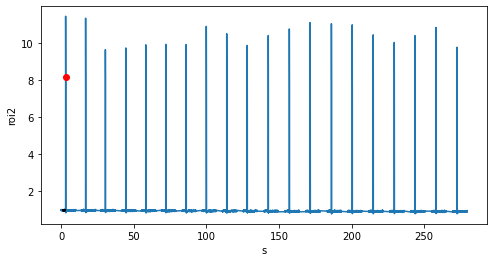

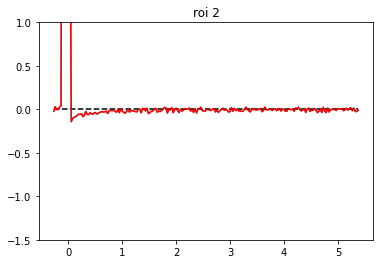

In [1]:
"""
Created on Wed Sep 30 12:59:13 2020

@author: kolbi

NOTES:
    Use for online analysis
    
USAGE:
    env: conda activate base2
    run from D:\pythonTesting\jg8-frap
    For un-normalized, plot N=20 pulses to get fraction change plot
    For normalized, plot N=5 pulses to get uncontaminated curves
    
NOTES:
        # roi1: frap pixel
        # roi2: frap roi
        # roi3: control roi within cell
        # roi4: neighboring cell roi <<< NOT PRESENT IN second experiment
        
        # @todo: check sampling rate
        
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os



plt.close('all')
num_peaks_to_plot = 1 # 40 # 'all' to plot all
length_to_plot = 200
samples_pre_stim = 10 # was 10
peak_thresh = 20000
plateau_start_idx = 100
plateau_end_idx = 20 # was 10

save_figs       = False
save_data       = False
normalize_roi   = True
keep_figs_open  = True # True to keep all generated figures open. Memory errors if too many open

'''
file name structure:
<data dir>/<exp_folder>/<filename>

where <filename> is <all_constructs[0].<all_cell_num[0]> e.g. 604.2.007

'''
data_dir = r'./data'
exp_folder = 'exp4_20201213'# 'exp3_20201211'
all_constructs = ['test']# [ '10.641', '604.2','500.688','500.686'] # '500.688', '604.2', '500.686'
all_cell_num = ['001']# ['001', '002', '003', '004', '005']


plateau_data = {} # dict for storing all plateau data
all_roi_avg_data = {} # 

for construct in all_constructs:
    
    plateau_data[construct] = []
    all_roi_avg_data[construct] = []
    
    for cell_num in all_cell_num:
        # construct = # '500.688' # '10.641', '500.456', '500.688'
        # cell_num = '004'
        filename = construct + '.' + cell_num + '.csv'
        data = pd.read_csv(os.path.join(data_dir,exp_folder, filename)) 
        

        
        t = data['Time [s]']
        
        # plot time diff trace
        # plt.figure()
        # plt.plot(np.diff(t))
        # plt.title('t')
        
        s_rate =1/ .027#(t[1]-t[0])
        roi1 = data['#1 (CSU (488))'].values
        roi2 = data['#2 (CSU (488))'].values
        roi3 = data['#3 (CSU (488))'].values
        # roi4 = data['#4 ( 1)'].values
        
        if normalize_roi:
            roi2 = roi2 / roi3
            roi3 = roi3 / roi3
            # roi4 = roi4 / roi3
            folder_name = 'normalized'
        else:
            folder_name = 'unnormalized'
            
        
        all_rois = (roi1, roi2, roi3) #, roi4)
        idx_peaks, _ = find_peaks(roi1, height=peak_thresh, distance=20)
        
        print('total number of stims: {}'.format(len(idx_peaks)))
        if num_peaks_to_plot != 'all':
            idx_peaks = idx_peaks[:num_peaks_to_plot]
        
        # adjust peak indices to find rightmost peak
        for i,_ in enumerate(idx_peaks):
            idx_peaks[i] += np.where(roi1[idx_peaks[i]:idx_peaks[i] +10] > peak_thresh)[0][-1]
        
        num_stims = len(idx_peaks)
        
        fig, raw_ax = plt.subplots()
        raw_ax.plot(t, roi2)
        raw_ax.plot(t[idx_peaks], roi2[idx_peaks], 'ro')
        raw_ax.set_xlabel("s")
        raw_ax.set_ylabel("roi2")

        # funcs to get plateau region
        plateau = lambda idx, r: r[idx-plateau_start_idx:idx-plateau_end_idx]
        plateau_t = lambda idx: t[idx-plateau_start_idx:idx-plateau_end_idx]
        
        # change in plateaus over time
        plateaus_roi1 = [plateau(i, roi1).mean() for i in idx_peaks] # plateaus from roi 2 (FRAP zone)
        plateaus_roi2 = [plateau(i, roi2).mean() for i in idx_peaks] # plateaus from roi 2 (FRAP zone)
        plateaus_roi3 = [plateau(i, roi3).mean() for i in idx_peaks] # plateaus from roi 3 (non-FRAP zone in same cell)
        # plateaus_roi4 = [plateau(i, roi4).mean() for i in idx_peaks] # plateaus from roi 2 (FRAP zone)
        
        # plot stim-triggered averages
        # fig_stimavg, ax = plt.subplots(1,4, sharex='all', sharey='all')
        fig_stimavg = plt.figure()
        fig.set_figwidth(8)
        for i,roi in enumerate(all_rois):
        
            
            t_combo = np.arange(-1*samples_pre_stim, length_to_plot)/s_rate
            # print(t_combo)
            roi_avg = np.zeros_like(t_combo)
            for j in range(num_stims):
                start_idx = idx_peaks[j]
                current_roi = roi[start_idx + np.arange(-1*samples_pre_stim,length_to_plot)]
                
                if i == 0:
                    current_roi = current_roi - plateaus_roi1[j]
                elif i == 1:
                    current_roi = current_roi - plateaus_roi2[j]
                    roi_avg += current_roi
                    plt.plot(t_combo, current_roi, 'gray')
                    plt.plot(t_combo, np.zeros_like(t_combo), 'k--')
                    plt.plot(t_combo, roi_avg, 'r-')
                    plt.title('roi ' + str(i+1))
                    if normalize_roi:
                        plt.ylim([-1.5, 1])
                    else:
                        plt.ylim([-1000, 500])
                elif i == 2:
                    current_roi = current_roi - plateaus_roi3[j]
#                elif i == 3:
#                    current_roi = current_roi - plateaus_roi4[j]
                
            
            roi_avg = roi_avg/(j+1)
            
            
            
            
            if i == 1: # roi 2 only (FRAP point)
                all_roi_avg_data[construct].append(roi_avg)
            
            
        
        # plot plateaus on entire timeseries and save (roi2 only)
        for i in idx_peaks:
            current_plateau = plateau(i, roi2)
            raw_ax.plot(plateau_t(i), current_plateau, 'k-')
            
            # plateau_data[construct].append(current_plateau.mean()) # add plateau mean to csv
        '''
        fig_plateaus, ax = plt.subplots()
        ax.plot(plateaus_roi2, 'ko-')
        ax.plot(plateaus_roi3, 'ro-')
        ax.legend(['FRAP zone (roi2)', 'non-FRAP zone (roi3)'])
        ax.set_title("plateaus")
        ax.set_xlabel("stim num")
        ax.set_ylabel("frap roi")
        
        # percent change in plateaus (next plateau - current plateau ) / current plateau
        percent_change = np.diff(plateaus_roi2) / plateaus_roi2[0:-1]
        fig_prcnt_chng = plt.figure()
        plt.plot(percent_change, 'ko-')
        plt.title("fraction change plateau")
        plt.xlabel("stim num")
        plt.ylabel("fraction change")
        
        plateau_data[construct].extend(percent_change)
        '''